<a href="https://colab.research.google.com/github/RiemanBall/Machine-Learning/blob/master/K_means/K_means_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement K-means from scratch
In this notebook, we will implement K-means from scratch with numpy and test the model with digit data from scikit-learn

In [1]:
from collections import defaultdict

import numpy as np
np.random.seed(0)

import sklearn.datasets as ds
from sklearn import preprocessing
from sklearn.cluster import KMeans as KMeans_skl # For comparison purpose
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

## Data Processing

### Loading data
With scikit learn, we load the 8x8 digits dataset.

In [2]:
digits = ds.load_digits()

X = digits.data
Y = digits.target

n_train, n_features = X.shape
n_digits = len(set(Y))

print(f"The number of training data: {n_train}")
print(f"The number of features: {n_features}")
print(f"The number of unique digits: {n_digits}")

The number of training data: 1797
The number of features: 64
The number of unique digits: 10


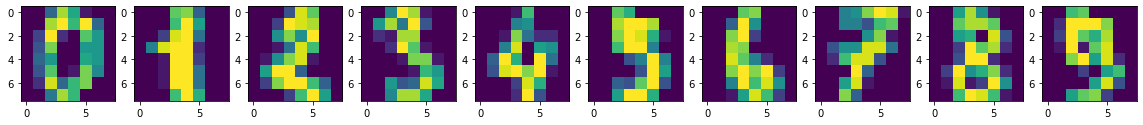

In [3]:
fig, axes = plt.subplots(figsize=(20, 50), nrows=1, ncols=n_digits, sharex=False)
for i, img in enumerate(X[:n_digits]):
    axes[i].imshow(img.reshape(8,8))

### Preprocess the dataset
- Normalize data

In [4]:
X = preprocessing.scale(X)

## K-means

In [5]:
# Helping functions
def get_euclidean_dist(f1: np.ndarray, f2: np.ndarray) -> float:
    '''
    Compute the Euclidean distance between two features
    Input:
        f1: (m, ) ndarray. feature set 1, m is the number of features
        f2: (m, ) ndarray. feature set 2, m is the number of features
    Output:
        float. Euclidean distance between two features
    '''
    return np.linalg.norm(f1 - f2)

In [6]:
class KMeans:
    def __init__(self, k = 10, n_init = 20, max_iter = 300, loss_tol = 1e-5, max_patience = 3):
        self.k = k
        self.n_init = 20
        self.max_iter = max_iter
        self.loss_tol = loss_tol
        self.loss = []
        self.max_patience = max_patience
        
        self.n_data = None
        self.n_features = None
        self.centroids = None # Will be k x m array
        self.clusters = None  # Will have k keys. Each key is one cluster containing the data points


    def get_loss(self)->float:
        '''
        Compute the sum of squared distance loss of current model
        '''
        loss = 0
        for cluster_id in self.clusters:
            centroid = self.centroids[cluster_id]
            loss += sum([get_euclidean_dist(centroid, feat) ** 2 for feat in self.clusters[cluster_id]])

        return loss / self.n_data


    def fit(self, X: np.ndarray):
        '''
        Fit the K-means model with training set X.
        Input:
            X: (n, m) ndarray. n is the number of data , m is the number of features
        Output:
            self.centroids: (k, m) ndarray. The centroids of each cluster.
            self.clusters: (n, m) ndarray. The clustered dataset
        '''
        self.n_data, self.n_features = X.shape
        
        # Initialize the centroids with k random features from the training set
        self.centroids = X[np.random.choice(self.n_data, self.k), :]

        patience = 0
        # Iteratively assgin data to clusters and update centroids
        for n_iter in range(self.max_iter):
            self.clusters = defaultdict(list)

            # Assign each data to a cluster:
            for x in X:
                # Compute distance of x to each centroid
                dists = [get_euclidean_dist(x, centroid) for centroid in self.centroids]
                # Find the cluster that is closest to x
                cluster_id = dists.index(min(dists))
                # Store x to the corresponding list
                self.clusters[cluster_id].append(x)

            # Update centroid:
            for cluster_id in self.clusters:
                self.centroids[cluster_id] = np.average(self.clusters[cluster_id], axis = 0)

            # Early exit: Check loss difference:
            cur_loss = self.get_loss()
            if self.loss and (np.abs(self.loss[-1] - cur_loss) < self.loss_tol):
                patience += 1
                if patience >= self.max_patience:
                    print(f"Converge at iteration {n_iter}!")
                    return
            else:
                patience = 0

            self.loss.append(cur_loss)

        return


    def predict(self, x: np.ndarray) -> int:
        '''
        Predict the cluster id of x.
        Input:
            x: (m, ) ndarray. Feature vector of a data point. m is the number of features.
        Output
            cluster_id: int. The id indicates which cluster x is classified to.
        '''
        dists = [get_euclidean_dist(x, centroid) for centroid in self.centroids]
        cluster_id = dists.index(min(dists))
        return cluster_id

## Train the K-means model

In [ ]:
k_means = KMeans()

# Train the k-means model
k_means.fit(X)

In [22]:
# Predict cluster id
Y_pred = np.array([k_means.predict(x) for x in X]).reshape(-1,)

### Plot losses

The loss of our K-means model is: 40.32912253560111


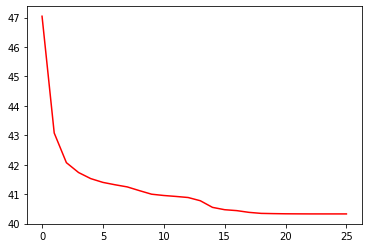

In [8]:
plt.plot(k_means.loss, 'r-')
print(f"The loss of our K-means model is: {k_means.loss[-1]}")

### Compare with Scikit learn

In [10]:
# Build a model
k_means_skl = KMeans_skl(n_clusters=10, n_init=20, random_state=23)

# We fit our data to assign classes
k_means_skl.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=23, tol=0.0001, verbose=0)

In [11]:
# Obtain the predictions
Y_pred_skl = k_means_skl.labels_

# Obtain cluster centers
centroids_skl = k_means_skl.cluster_centers_

# Compute the sum of squared distance as loss
loss = 0
for ind, cluster_id in enumerate(Y_pred_skl):
    centroid = centroids_skl[cluster_id]
    feat = X[ind]
    loss += get_euclidean_dist(centroid, feat) ** 2

loss = loss / X.shape[0]

print(f"The loss of sklearn K-means model is: {loss}")

The loss of sklearn K-means model is: 38.82082804141076


## Visualize the K-means model
Here we will
- plot each centroid
- visualize by using t-SNE

### Plot centroids

#### Our model

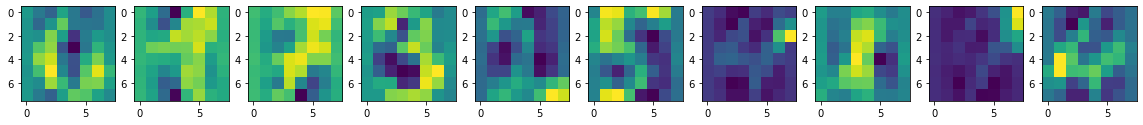

In [12]:
centroids_img = np.zeros((n_digits, 8, 8))

for id in range(10):
    centroids_img[id] = k_means.centroids[id].reshape(8, 8)

fig, axes = plt.subplots(figsize=(20, 50), nrows=1, ncols=n_digits, sharex=False)
for i, img in enumerate(centroids_img):
    axes[i].imshow(img)

#### Scikit Learn model

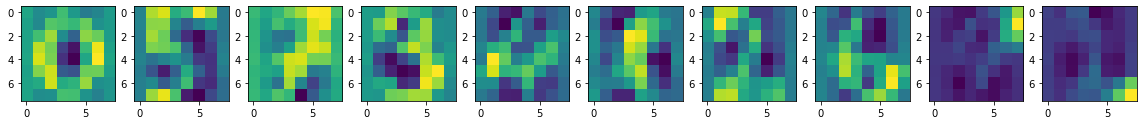

In [13]:
centroids_img_skl = np.zeros((n_digits, 8, 8))

for id in range(10):
    centroids_img_skl[id] = centroids_skl[id].reshape(8, 8)

fig, axes = plt.subplots(figsize=(20, 50), nrows=1, ncols=n_digits, sharex=False)
for i, img in enumerate(centroids_img_skl):
    axes[i].imshow(img)

### t-SNE

In [14]:
# Perform t-SNE manifold learning on the digit data
x_tsne = TSNE(n_components=2, perplexity=50, n_iter=250, random_state=23, n_jobs=-1).fit(X)

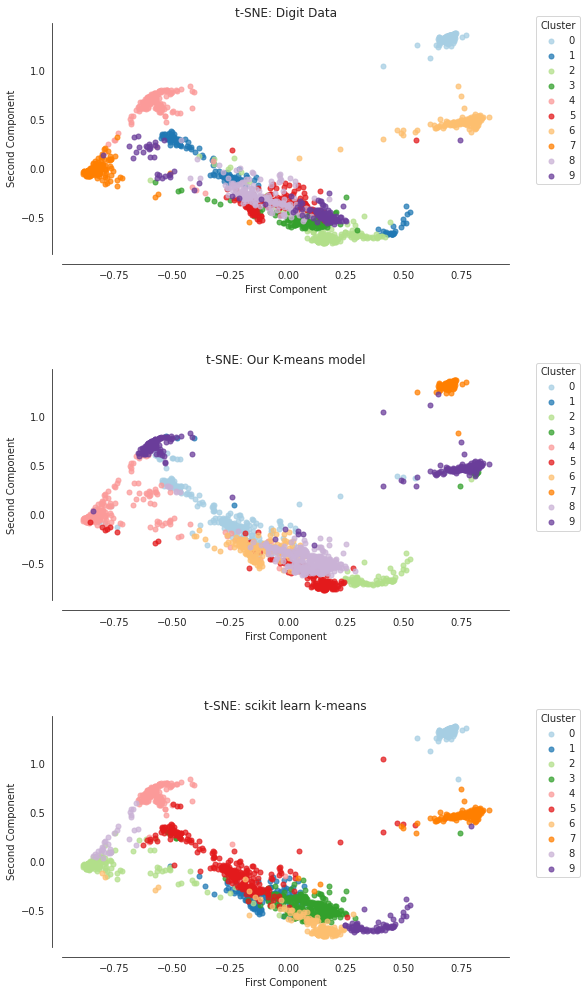

In [25]:
# Color map
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style('white')

my_cmap = ListedColormap(sns.color_palette("Paired", n_digits))

# Create Figure and axes
fig, axs = plt.subplots(figsize=(8, 17), nrows=3, ncols=1, sharex=False)
plt.subplots_adjust(hspace=0.5)

# Plot each class separately
for digit in range(n_digits):
    xy_data = x_tsne.embedding_[(Y == digit)]
    xy_k_means_skl = x_tsne.embedding_[(Y_pred_skl == digit)]
    xy_k_means = x_tsne.embedding_[(Y_pred == digit)]
        
    # Plot the instances of each class in projected dimensions
    axs[0].scatter(xy_data[:, 0], xy_data[:, 1], s=25, 
                   color=my_cmap(digit), alpha=0.75,
                   label=f'{digit}')
    
    axs[1].scatter(xy_k_means[:, 0], xy_k_means[:, 1], s=25, 
                   color=my_cmap(digit), alpha=0.75,
                   label=f'{digit}')
    
    axs[2].scatter(xy_k_means_skl[:, 0], xy_k_means_skl[:, 1], s=25, 
                   color=my_cmap(digit), alpha=0.75,
                   label=f'{digit}')

    # Decorate plots with legend
    axs[0].legend(title='Cluster', fontsize='medium', 
                  bbox_to_anchor=(1.05, 1.05))
    axs[1].legend(title='Cluster', fontsize='medium', 
                  bbox_to_anchor=(1.05, 1.05))
    axs[2].legend(title='Cluster', fontsize='medium', 
                  bbox_to_anchor=(1.05, 1.05))

    #Decorate plot with title and labels
    axs[0].set(title=f't-SNE: Digit Data',
               xlabel='First Component',
               ylabel='Second Component')
    axs[1].set(title=f't-SNE: Our K-means model',
               xlabel='First Component',
               ylabel='Second Component')
    axs[2].set(title=f't-SNE: scikit learn k-means',
               xlabel='First Component',
               ylabel='Second Component')        

    # Clean plot
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[2].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[2].spines['right'].set_visible(False)

    sns.despine(ax=axs[0], offset=10)
    sns.despine(ax=axs[1], offset=10)   
    sns.despine(ax=axs[2], offset=10)   